In [1]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 8.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:

import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### Importing Libraries

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import string
from nltk.corpus import stopwords
from tqdm import tqdm

import nltk
from datasets import load_dataset
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from transformers import T5Tokenizer
import torch

from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torch.optim import Adam

In [5]:
warnings.filterwarnings('ignore')

### Loading Datasets

In [6]:
metaData = load_dataset('wikisql')

Generating test split:   0%|          | 0/15878 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/8421 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/56355 [00:00<?, ? examples/s]

In [7]:
metaData

DatasetDict({
    test: Dataset({
        features: ['phase', 'question', 'table', 'sql'],
        num_rows: 15878
    })
    validation: Dataset({
        features: ['phase', 'question', 'table', 'sql'],
        num_rows: 8421
    })
    train: Dataset({
        features: ['phase', 'question', 'table', 'sql'],
        num_rows: 56355
    })
})

In [8]:
trainSampleDataset = []
for each in tqdm(metaData['train']):
    row = { 'question': each['question'], 'sql': each['sql']['human_readable']}
    trainSampleDataset.append(row)
trainDataFrame = pd.DataFrame(trainSampleDataset)

100%|██████████| 56355/56355 [00:57<00:00, 978.92it/s] 


In [9]:
trainDataFrame.head()

,question,sql
0,Tell me what the notes are for South Australia,SELECT Notes FROM table WHERE Current slogan =...
1,What is the current series where the new serie...,SELECT Current series FROM table WHERE Notes =...
2,What is the format for South Australia?,SELECT Format FROM table WHERE State/territory...
3,Name the background colour for the Australian ...,SELECT Text/background colour FROM table WHERE...
4,how many times is the fuel propulsion is cng?,SELECT COUNT Fleet Series (Quantity) FROM tabl...


In [10]:
validationSampleDataset = []
for each in tqdm(metaData['validation']):
    row = { 'question': each['question'], 'sql': each['sql']['human_readable']}
    validationSampleDataset.append(row)
validationDataFrame = pd.DataFrame(validationSampleDataset)

100%|██████████| 8421/8421 [00:02<00:00, 3447.02it/s]


In [11]:
validationDataFrame.head()

,question,sql
0,What position does the player who played for b...,SELECT Position FROM table WHERE School/Club T...
1,How many schools did player number 3 play at?,SELECT COUNT School/Club Team FROM table WHERE...
2,What school did player number 21 play for?,SELECT School/Club Team FROM table WHERE No. = 21
3,Who is the player that wears number 42?,SELECT Player FROM table WHERE No. = 42
4,What player played guard for toronto in 1996-97?,SELECT Player FROM table WHERE Position = Guar...


In [12]:
testSampleDataset = []
for each in tqdm(metaData['test']):
    row = { 'question': each['question'], 'sql': each['sql']['human_readable']}
    testSampleDataset.append(row)
testDataFrame = pd.DataFrame(testSampleDataset)

100%|██████████| 15878/15878 [00:04<00:00, 3267.74it/s]


In [13]:
testDataFrame

,question,sql
0,What is terrence ross' nationality,SELECT Nationality FROM table WHERE Player = T...
1,What clu was in toronto 1995-96,SELECT School/Club Team FROM table WHERE Years...
2,which club was in toronto 2003-06,SELECT School/Club Team FROM table WHERE Years...
3,how many schools or teams had jalen rose,SELECT COUNT School/Club Team FROM table WHERE...
4,Where was Assen held?,SELECT Round FROM table WHERE Circuit = Assen
...,...,...
15873,"After 1972, how many points did Marlboro Team ...",SELECT Points FROM table WHERE Year > 1972 AND...
15874,What chassis had 39 points?,SELECT Chassis FROM table WHERE Points = 39
15875,How many points did the Ford V8 with a Tyrrell...,SELECT Points FROM table WHERE Engine = ford v...
15876,"Before 1976 and with 12 points, what chassis d...",SELECT Chassis FROM table WHERE Engine = ford ...


In [14]:
df = pd.concat([trainDataFrame, validationDataFrame, testDataFrame])

In [15]:
df = trainDataFrame.copy()

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56355 entries, 0 to 56354
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  56355 non-null  object
 1   sql       56355 non-null  object
dtypes: object(2)
memory usage: 880.7+ KB


In [17]:
df.isnull().sum()

question    0
sql         0
dtype: int64

### Converting values to lower case

In [18]:
df['question'] = df['question'].str.lower()

In [19]:
df['sql'] = df['sql'].str.lower()

In [20]:
df.head()

,question,sql
0,tell me what the notes are for south australia,select notes from table where current slogan =...
1,what is the current series where the new serie...,select current series from table where notes =...
2,what is the format for south australia?,select format from table where state/territory...
3,name the background colour for the australian ...,select text/background colour from table where...
4,how many times is the fuel propulsion is cng?,select count fleet series (quantity) from tabl...


### Removing Punctuations

In [21]:
def Punctuations(sentence):
    return sentence.translate(str.maketrans('', '', string.punctuation))

In [22]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [23]:
df['question'] = df['question'].apply(Punctuations)

In [24]:
df.head()

,question,sql
0,tell me what the notes are for south australia,select notes from table where current slogan =...
1,what is the current series where the new serie...,select current series from table where notes =...
2,what is the format for south australia,select format from table where state/territory...
3,name the background colour for the australian ...,select text/background colour from table where...
4,how many times is the fuel propulsion is cng,select count fleet series (quantity) from tabl...


### Removing stop words

In [25]:
sql_stopwords = ['SELECT', 'FROM', 'WHERE', 'AND', 'OR', 'NOT', 'AS', 'IN', 'ON', 'JOIN', 'INNER', 'LEFT', 'RIGHT', 'OUTER', 'GROUP', 'BY', 'HAVING', 'ORDER', 'ASC', 'DESC', 'LIMIT', 'OFFSET', 'DISTINCT', 'ALL', 'UNION', 'EXCEPT', 'INTERSECT']
print(f'Number of stop words that are present in sql: {len(sql_stopwords)}')

Number of stop words that are present in sql: 27


In [26]:
for i in range(len(sql_stopwords)):
    sql_stopwords[i] = sql_stopwords[i].lower()

In [27]:
stopWords = stopwords.words('english')
print(f'Number of stop words that are present in english: {len(sql_stopwords)}')

Number of stop words that are present in english: 27


In [28]:
for i in sql_stopwords:
    if i in stopWords:
        stopWords.remove(i)

In [29]:
print(f'Final stopwords list length: {len(stopWords)}')

Final stopwords list length: 168


In [30]:
def stopWordsRemove(sentence):
    finalSentence = ""
    for word in sentence.split():
        if word not in stopWords:
            finalSentence += word + " "
    finalSentence = finalSentence.strip()
    return finalSentence


In [31]:
df['question'] = df['question'].apply(stopWordsRemove)

### Lemmatization

In [32]:
lemma = WordNetLemmatizer()

In [33]:
def lemmatization(text):
    return " ".join([lemma.lemmatize(word, pos = 'n') for word in text.split()])

In [34]:
df['question'] = df['question'].apply(lemmatization)

### Removing Extra Punctuations in SQL

In [35]:
punctuations = string.punctuation
punctuations = punctuations.replace('=', '').replace('(', '').replace(')', '').replace('/', '')

In [36]:
punctuations

'!"#$%&\'*+,-.:;<>?@[\\]^_`{|}~'

In [37]:
def deletePunctuationSQL(sentence):
    for char in punctuations:
        sentence = sentence.replace(char, '')
    return sentence

In [38]:
df['sql'] = df['sql'].apply(deletePunctuationSQL)

### Graph Visualization

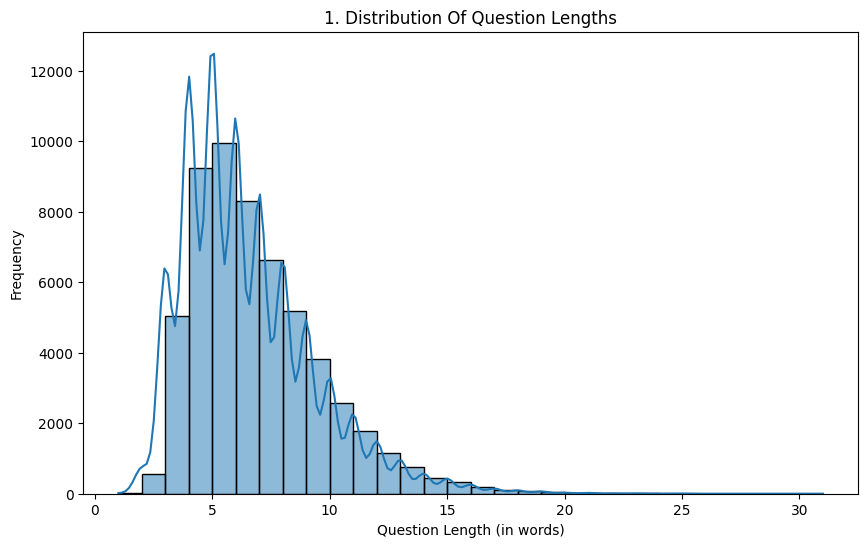

In [39]:
df['questionTokens'] = df['question'].apply(lambda x: len(x.split()))
plt.figure(figsize = (10, 6))

sns.histplot(df['questionTokens'], bins = 30, kde = True)
plt.title('1. Distribution Of Question Lengths')
plt.xlabel('Question Length (in words)')
plt.ylabel('Frequency')
plt.show()

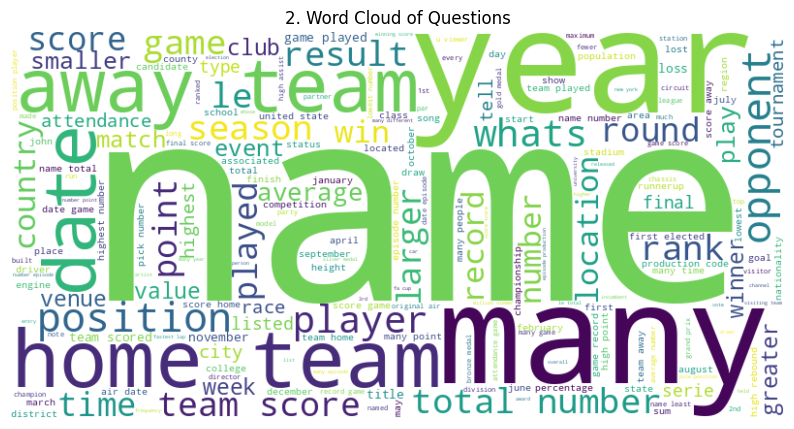

In [40]:
all_questions = ' '.join(df['question'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(all_questions)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('2. Word Cloud of Questions')
plt.show()


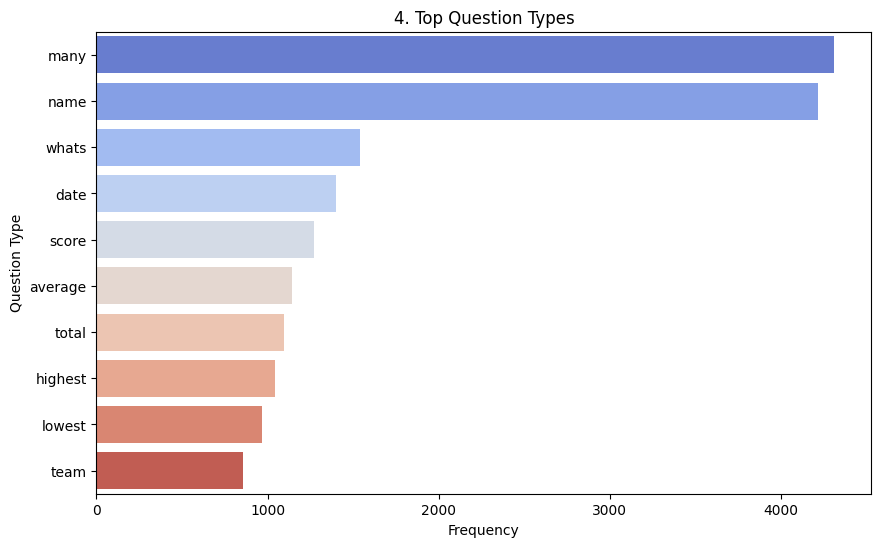

In [41]:
df['questionType'] = df['question'].apply(lambda x: x.split()[0].lower())
question_type_counts = df['questionType'].value_counts().head(10)
question_type_counts = question_type_counts.reset_index()
question_type_counts.columns = ['Question Type', 'Frequency']
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Question Type', data=question_type_counts, palette='coolwarm')
plt.title('4. Top Question Types')
plt.xlabel('Frequency')
plt.ylabel('Question Type')
plt.show()


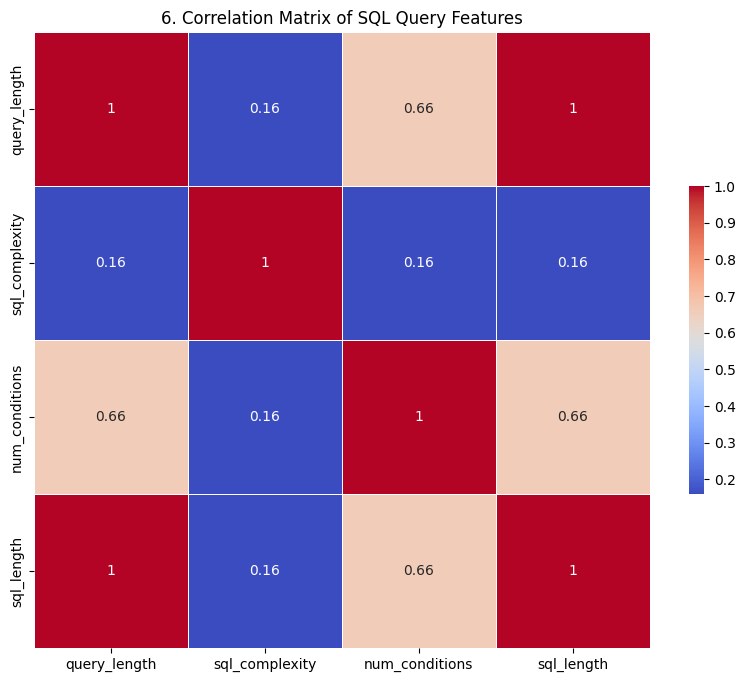

In [42]:
dv=df.copy()

dv['query_length'] = df['sql'].apply(lambda x: len(x.split()))
dv['sql_complexity'] = df['sql'].apply(lambda x: x.upper().count('SELECT') + x.upper().count('WHERE'))
dv['num_conditions'] = df['sql'].apply(lambda x: x.upper().count('AND') + x.upper().count('OR') + 1 if 'WHERE' in x.upper() else 0)
dv['sql_length'] = df['sql'].apply(lambda x: len(x.split()))
corr_matrix = dv[['query_length', 'sql_complexity', 'num_conditions', 'sql_length']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('6. Correlation Matrix of SQL Query Features')
plt.show()



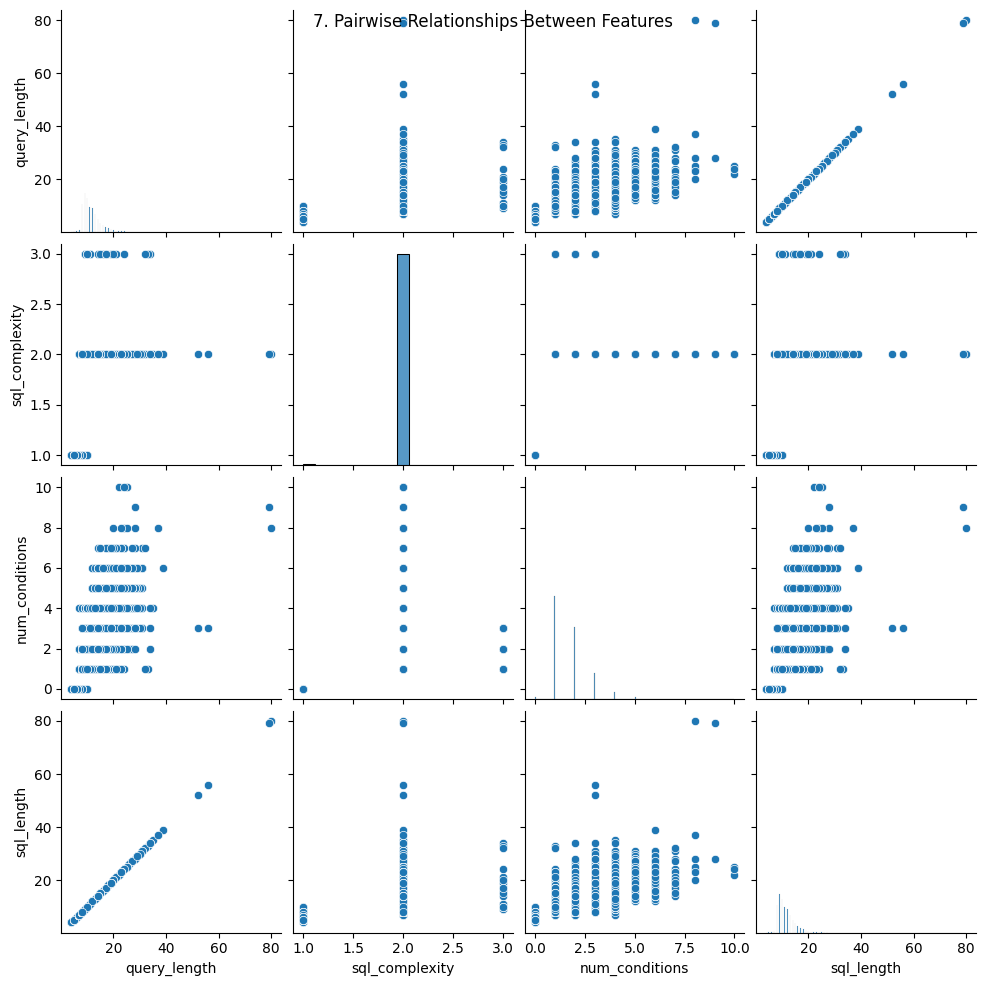

In [43]:
sns.pairplot(dv[['query_length', 'sql_complexity', 'num_conditions', 'sql_length']])
plt.suptitle('7. Pairwise Relationships Between Features', verticalalignment='top')
plt.show()

### Splitting the dataset

In [44]:
X = df['question'].tolist()
y = df['sql'].tolist()

### Checking for GPU

In [45]:
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained('t5-small')
def tokenize_texts(text_list, max_length=512):
    return tokenizer(
        text_list,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='np'
    )

X_tokenized = tokenize_texts(X)
y_tokenized = tokenize_texts(y)


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [46]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X_tokenized['input_ids'], y_tokenized['input_ids'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [47]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, LayerNormalization, Dropout, MultiHeadAttention

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout_rate):
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attention = Dropout(dropout_rate)(attention)
    attention = LayerNormalization(epsilon=1e-6)(attention + inputs)

    ff_output = Dense(ff_dim, activation='relu')(attention)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    encoder_output = LayerNormalization(epsilon=1e-6)(ff_output + attention)
    return encoder_output

def transformer_decoder(inputs, enc_output, head_size, num_heads, ff_dim, dropout_rate):
    self_attention = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    self_attention = Dropout(dropout_rate)(self_attention)
    self_attention = LayerNormalization(epsilon=1e-6)(self_attention + inputs)

    attention = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(self_attention, enc_output)
    attention = Dropout(dropout_rate)(attention)
    attention = LayerNormalization(epsilon=1e-6)(attention + self_attention)

    ff_output = Dense(ff_dim, activation='relu')(attention)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    decoder_output = LayerNormalization(epsilon=1e-6)(ff_output + attention)
    return decoder_output


embedding_dim = 256
vocab_size = 32128
head_size = 64
num_heads = 8
ff_dim = 512
dropout_rate = 0.1
max_length = 512

inputs_enc = Input(shape=(None,))
inputs_dec = Input(shape=(None,))

enc_emb = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs_enc)
dec_emb = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs_dec)

enc_output = transformer_encoder(enc_emb, head_size, num_heads, ff_dim, dropout_rate)
dec_output = transformer_decoder(dec_emb, enc_output, head_size, num_heads, ff_dim, dropout_rate)

final_output = Dense(vocab_size, activation='softmax')(dec_output)

model = Model(inputs=[inputs_enc, inputs_dec], outputs=final_output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 256)            8224768   ['input_1[0][0]']             
                                                                                                  
 multi_head_attention (Mult  (None, None, 256)            526080    ['embedding[0][0]',           
 iHeadAttention)                                                     'embedding[0][0]']           
                                                                                                  
 dropout (Dropout)           (None, None, 256)            0         ['multi_head_attention[0][

In [48]:
import numpy as np


y_train_shifted = np.pad(y_train[:, :-1], ((0, 0), (1, 0)), mode='constant', constant_values=tokenizer.pad_token_id)
y_val_shifted = np.pad(y_val[:, :-1], ((0, 0), (1, 0)), mode='constant', constant_values=tokenizer.pad_token_id)


In [ ]:

history = model.fit(
    [X_train, y_train_shifted],
    y_train,
    validation_data=([X_val, y_val_shifted], y_val),
    batch_size=256,
    epochs=10
)


Epoch 1/10
250/250 [==============================] - 64s 224ms/step - loss: 0.5872 - val_loss: 0.1339
Epoch 2/10
250/250 [==============================] - 42s 167ms/step - loss: 0.1182 - val_loss: 0.1243
Epoch 3/10
250/250 [==============================] - 41s 165ms/step - loss: 0.1028 - val_loss: 0.1222
Epoch 4/10
250/250 [==============================] - 41s 164ms/step - loss: 0.0957 - val_loss: 0.1224
Epoch 5/10
250/250 [==============================] - 40s 158ms/step - loss: 0.0926 - val_loss: 0.1235
Epoch 6/10
250/250 [==============================] - 41s 163ms/step - loss: 0.0911 - val_loss: 0.1241
Epoch 7/10
250/250 [==============================] - 40s 158ms/step - loss: 0.0904 - val_loss: 0.1254
Epoch 8/10
250/250 [==============================] - 40s 161ms/step - loss: 0.0898 - val_loss: 0.1255
Epoch 9/10
250/250 [==============================] - 41s 163ms/step - loss: 0.0892 - val_loss: 0.1265
Epoch 10/10
250/250 [==============================] - 40s 161ms/step - l

In [ ]:
model.save('my_transformer_model.h5')

from tensorflow.keras.models import load_model
loaded_model = load_model('my_transformer_model.h5')


In [50]:
def predict_sql(query, tokenizer, model, max_length=512):

    input_ids = tokenizer(
        query,
        return_tensors='np',
        padding='max_length',
        truncation=True,
        max_length=max_length
    )['input_ids']


    decoder_input = np.full((1, max_length), fill_value=tokenizer.pad_token_id)

    decoder_input[0, 0] = tokenizer.pad_token_id
    for i in range(1, max_length):

        predictions = model.predict([input_ids, decoder_input])[0, i-1, :]
        predicted_token_id = np.argmax(predictions)
        decoder_input[0, i] = predicted_token_id

        if predicted_token_id == tokenizer.eos_token_id:
            break
    predicted_sql = tokenizer.decode(decoder_input[0], skip_special_tokens=True)
    return predicted_sql


In [57]:
input_sentence = "what is the age of the girl named lucky"
predicted_sql_query = predict_sql(input_sentence, tokenizer, model, max_length=20)
print(f'Predicted SQL query: {predicted_sql_query}')

1/1 [==============================] - 0s 117ms/step
Predicted SQL query: select select age age age from table lucky = name


In [ ]:
train_losses = history.history['loss']
validation_losses = history.history['val_loss']


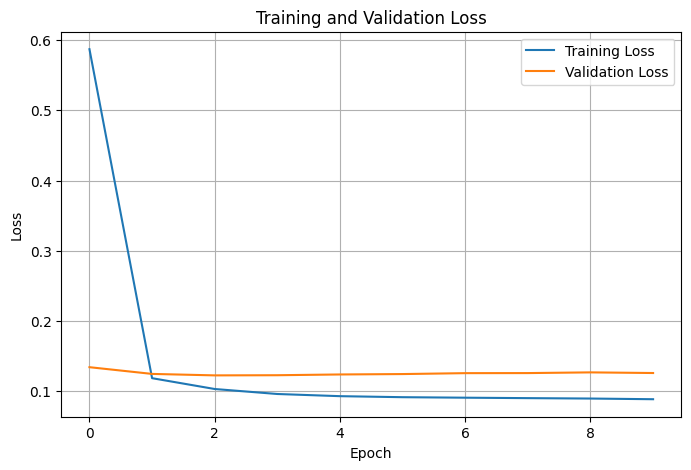

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# Optimization Technique 1

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1, mode='min')
model = Model(inputs=[inputs_enc, inputs_dec], outputs=final_output)
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=3e-03)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')


In [ ]:
history = model.fit(
    [X_train, y_train_shifted],
    y_train,
    validation_data=([X_val, y_val_shifted], y_val),
    batch_size=256,
    epochs=10,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/10
250/250 [==============================] - 52s 172ms/step - loss: 0.8453 - val_loss: 0.3124 - lr: 0.0010
Epoch 2/10
250/250 [==============================] - 37s 150ms/step - loss: 0.3016 - val_loss: 0.2878 - lr: 0.0010
Epoch 3/10
250/250 [==============================] - 37s 150ms/step - loss: 0.2770 - val_loss: 0.2619 - lr: 0.0010
Epoch 4/10
250/250 [==============================] - 38s 152ms/step - loss: 0.2522 - val_loss: 0.2378 - lr: 0.0010
Epoch 5/10
250/250 [==============================] - 38s 154ms/step - loss: 0.2320 - val_loss: 0.2223 - lr: 0.0010
Epoch 6/10
250/250 [==============================] - 40s 159ms/step - loss: 0.2207 - val_loss: 0.2155 - lr: 0.0010
Epoch 7/10
250/250 [==============================] - 41s 163ms/step - loss: 0.2155 - val_loss: 0.2122 - lr: 0.0010
Epoch 8/10
250/250 [==============================] - 41s 162ms/step - loss: 0.2125 - val_loss: 0.2098 - lr: 0.0010
Epoch 9/10
250/250 [==============================] - 40s 162ms/step - l

In [ ]:
test_loss = model.evaluate(
    [X_test, y_test],
    y_test
)

print("Test Loss:", test_loss)


250/250 [==============================] - 5s 19ms/step - loss: 0.2480
Test Loss: 0.2479938268661499


In [ ]:
def predict_sql(query, tokenizer, model, max_length=512):

    input_ids = tokenizer(
        query,
        return_tensors='np',
        padding='max_length',
        truncation=True,
        max_length=max_length
    )['input_ids']


    decoder_input = np.full((1, max_length), fill_value=tokenizer.pad_token_id)


    decoder_input[0, 0] = tokenizer.pad_token_id


    for i in range(1, max_length):

        predictions = model.predict([input_ids, decoder_input])[0, i-1, :]
        predicted_token_id = np.argmax(predictions)
        decoder_input[0, i] = predicted_token_id

        if predicted_token_id == tokenizer.eos_token_id:
            break

    predicted_sql = tokenizer.decode(decoder_input[0], skip_special_tokens=True)
    return predicted_sql


In [59]:
input_sentence = "what is the age of the girl named lucky"
predicted_sql_query = predict_sql(input_sentence, tokenizer, model, max_length=20)
print(f' Predicted SQL Query: {predicted_sql_query}')


1/1 [==============================] - 0s 65ms/step
 Predicted SQL Query: select from table table tablet table table table


In [ ]:
train_losses = history.history['loss']
validation_losses = history.history['val_loss']


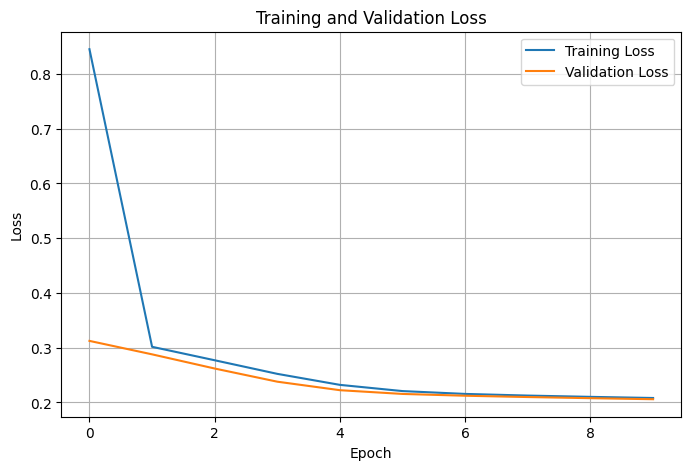

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


#Optimization Techniques 2

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1, mode='min')
model = Model(inputs=[inputs_enc, inputs_dec], outputs=final_output)
optimizer = RMSprop(learning_rate=5e-01, rho=0.8, epsilon=5e-01)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')


In [ ]:
history = model.fit(
    [X_train, y_train_shifted],
    y_train,
    validation_data=([X_val, y_val_shifted], y_val),
    batch_size=256,
    epochs=10,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/10
250/250 [==============================] - 55s 179ms/step - loss: 0.1874 - val_loss: 0.1733 - lr: 0.5000
Epoch 2/10
250/250 [==============================] - 37s 150ms/step - loss: 0.1679 - val_loss: 0.1623 - lr: 0.5000
Epoch 3/10
250/250 [==============================] - 38s 152ms/step - loss: 0.1588 - val_loss: 0.1559 - lr: 0.5000
Epoch 4/10
250/250 [==============================] - 38s 152ms/step - loss: 0.1523 - val_loss: 0.1512 - lr: 0.5000
Epoch 5/10
250/250 [==============================] - 38s 153ms/step - loss: 0.1471 - val_loss: 0.1480 - lr: 0.5000
Epoch 6/10
250/250 [==============================] - 39s 157ms/step - loss: 0.1428 - val_loss: 0.1452 - lr: 0.5000
Epoch 7/10
250/250 [==============================] - 39s 156ms/step - loss: 0.1394 - val_loss: 0.1440 - lr: 0.5000
Epoch 8/10
250/250 [==============================] - 40s 159ms/step - loss: 0.1362 - val_loss: 0.1408 - lr: 0.5000
Epoch 9/10
250/250 [==============================] - 40s 158ms/step - l

In [ ]:
test_loss = model.evaluate(
    [X_test, y_test],
    y_test
)

print("Test Loss:", test_loss)


250/250 [==============================] - 5s 19ms/step - loss: 0.3104
Test Loss: 0.3103677034378052


In [60]:
input_sentence = "what is the age of the girl named lucky"
predicted_sql_query = predict_sql(input_sentence, tokenizer, model, max_length=20)
print(f'Predicted SQL query: {predicted_sql_query}')

1/1 [==============================] - 0s 153ms/step
Predicted SQL query: the age of the player lucky lucky lucky what is the age of the player lucky what is the age of the player lucky what is the age of the player lucky what is the age of the player lucky what is the age of the player lucky what is the age of the player lucky what is the age of the player lucky what is the age of the player lucky what is


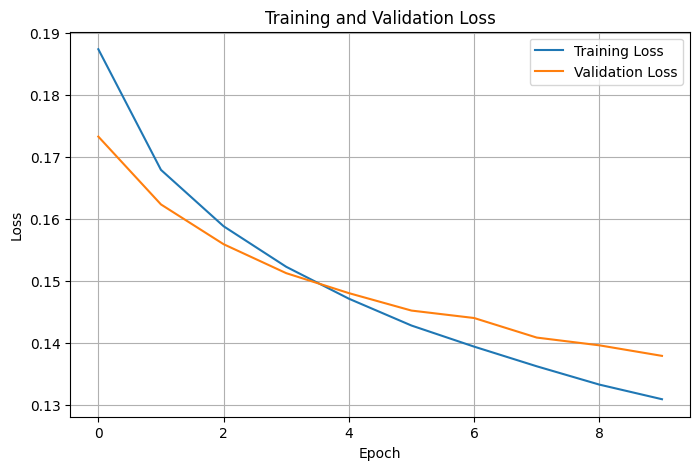

In [ ]:
train_losses = history.history['loss']
validation_losses = history.history['val_loss']
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
